# Visualising trials from Fast AutoAugment

In this notebook, I aim to understand how Fast AutoAugment found the optimal data augmentation policies for CIFAR-10.

In the bayesian optimization loop I designed, at each round, the evaluation function receives a randomly selected sub-policy that has two operations with their probabilities and magnitudes. The function saves the sub-policy and its validation loss to Trials. I'm going to delve into the Trials and visualize the relationship between validation error (that we are aiming to minimize) and operations.

To focus on an operation at a time, I de-coupled 2 operations with their joint validation loss. This might weaken the interpretation but it shows the general trend. 

In [84]:
import os
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
cv_folds = 5
search_width = 2
search_results_folder = 'fastautoaugment'

In [86]:
records = []

for k_idx in range(cv_folds):

    T_star_k_idx = []

    for t_idx in range(search_width):
        trials = pickle.load(
            open(os.path.join(search_results_folder, "k{}_t{}_trials.pkl".format(k_idx, t_idx)), "rb"))

        val_error_list = [t['result']['loss'] for t in trials.trials]
        trial_records = [t['misc']['vals'] for t in trials.trials]
        
        for ops, loss in zip(trial_records, val_error_list):
            for op, val in ops.items():
                _, op_name, op_type = op.split("_")
                records.append({"op_name": op_name,
                "op_type": op_type,
                "val": val[0],
                "loss": loss})

In [87]:
records_df = pd.DataFrame(records)
pivoted = pd.pivot_table(records_df, index=['op_name', 'loss'], columns='op_type').reset_index()

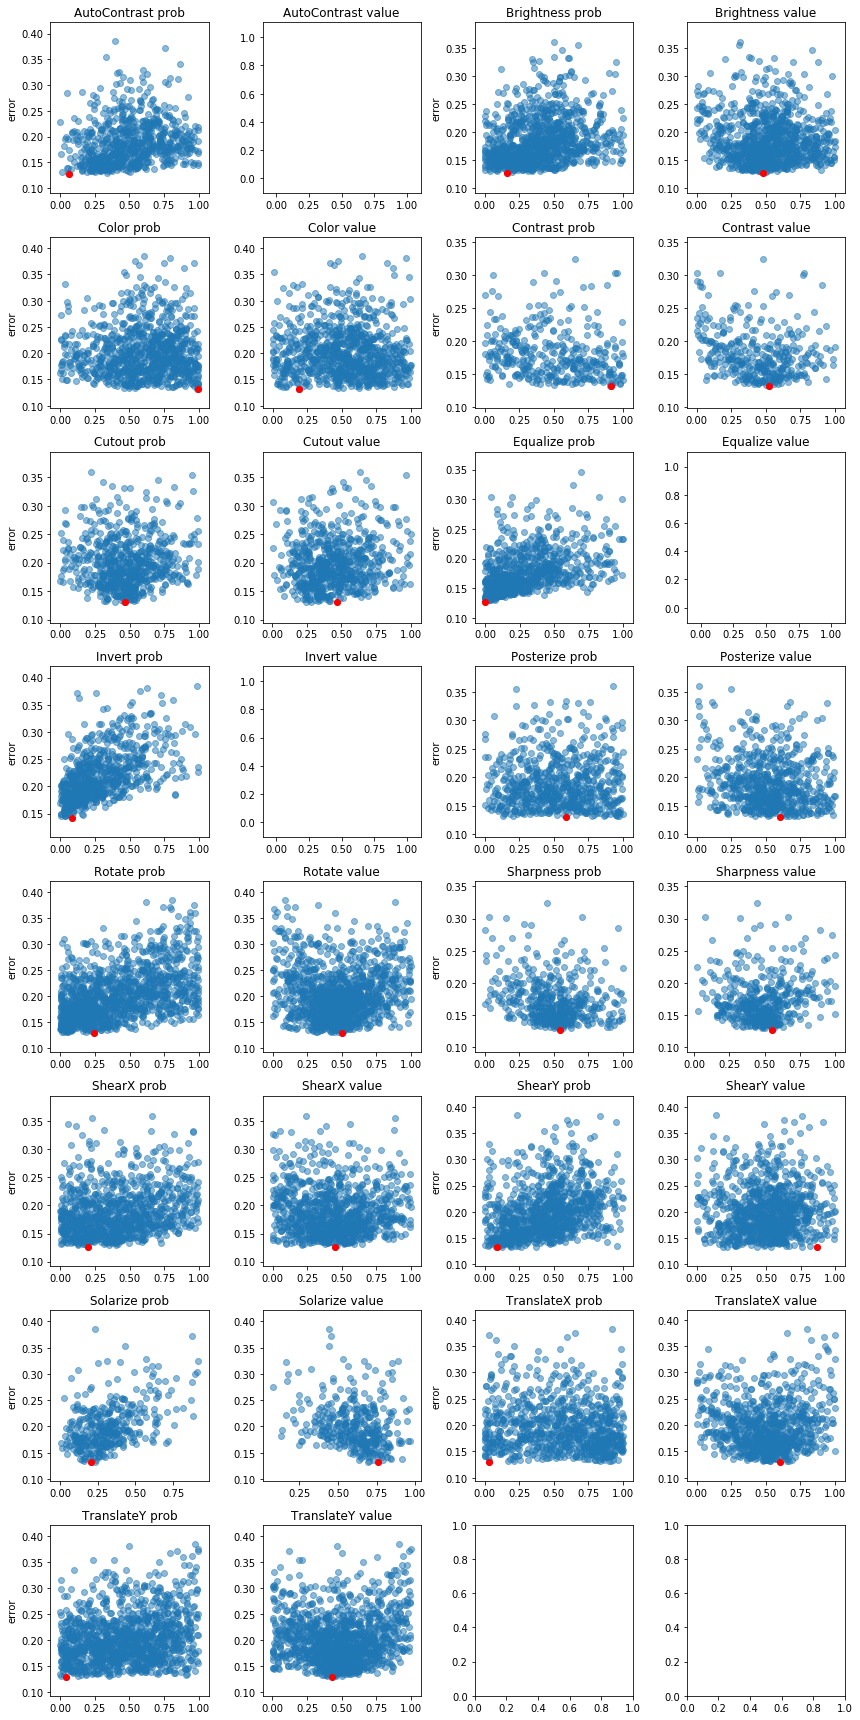

In [88]:
g = pivoted.groupby('op_name')

fig, ax = plt.subplots(8, 4, figsize=(12, 24))

for idx, (label, data) in enumerate(g):
    
    nrow = idx // 2
    isEven = int((idx+1) % 2 == 0)
    
    minimum_record = data.iloc[np.argmin(np.array(data.loss))]
    
    ax[nrow, isEven*2].scatter(data.val.p, data.loss, alpha=0.5)
    ax[nrow, isEven*2].scatter(minimum_record.val.p, minimum_record.loss, color='red')
    if not data.val.v.iloc[0] == 'None':
        ax[nrow, isEven*2+1].scatter(data.val.v, data.loss, alpha=0.5)
        ax[nrow, isEven*2+1].scatter(minimum_record.val.v, minimum_record.loss, color='red')
    ax[nrow, isEven*2].set_title(label + " prob")
    ax[nrow, isEven*2+1].set_title(label + " value")
    
    ax[nrow, isEven*2].set_ylabel("error")
    
#     ax[nrow, isEven*2].set_ylim(0.1, 0.2)
#     ax[nrow, isEven*2+1].set_ylim(0.1, 0.2)
plt.tight_layout()    
plt.show()